# Differential Expression Analysis for CCC & Downstream Signalling Networks

https://liana-py.readthedocs.io/en/latest/notebooks/targeted.html

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc

import plotnine as p9

import liana as li

# load muon and mofax
import muon as mu
# import mofax as mofa

import decoupler as dc

In [34]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
adata = li.testing.datasets.kang_2018()
adata

  0%|          | 0.00/36.6M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [27]:
adata.X.max()

3828.0

In [28]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [29]:
sample_key = 'sample'
condition_key = 'condition'
groupby = 'cell_abbr'

... storing 'sample' as categorical
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


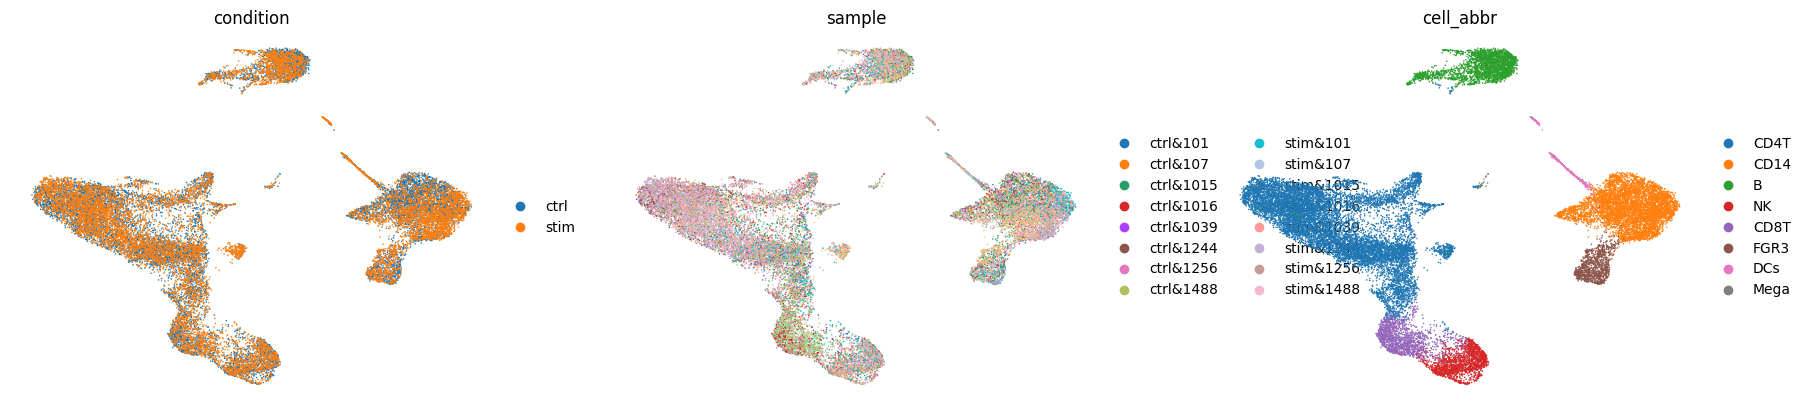

In [30]:
sc.pl.umap(adata, color=[condition_key, sample_key, groupby], frameon=False, ncols=3)

In [31]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)
pdata

AnnData object with n_obs × n_vars = 110 × 15701
    obs: 'condition', 'cell_type', 'patient', 'sample', 'cell_abbr', 'psbulk_n_cells', 'psbulk_counts'
    var: 'name', 'n_cells'
    layers: 'psbulk_props'

In [35]:
%%capture

dea_results = {}
quiet = True

for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()

    # Obtain genes that pass the edgeR-like thresholds
    # NOTE: QC thresholds might differ between cell types, consider applying them by cell type
    genes = dc.filter_by_expr(ctdata,
                              group=condition_key,
                              min_count=5, # a minimum number of counts in a number of samples
                              min_total_count=10 # a minimum total number of reads across samples
                              )

    # Filter by these genes
    ctdata = ctdata[:, genes].copy()

    # Build DESeq2 object
    # NOTE: this data is actually paired, so one could consider fitting the patient label as a confounder
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'ctrl'], # set control as reference
        refit_cooks=True,
        quiet=quiet
    )

    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, 'stim', 'ctrl'], quiet=quiet)
    stat_res.quiet = quiet
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff='condition_stim_vs_ctrl') # {condition_key}_cond_vs_ref

    dea_results[cell_group] = stat_res.results_df

In [36]:
dea_results

{'B':            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
 index                                                                      
 AAED1      7.282872       -0.120895  0.284588 -0.517852  0.604561  0.790303
 AAMP      11.967019       -0.401260  0.222882 -1.997275  0.045795  0.140543
 AARS       5.797380        0.149815  0.301563  0.609857  0.541956  0.744820
 AASDHPPT   6.147571        0.186321  0.298391  0.761277  0.446491  0.668988
 AATF       9.567191       -0.108041  0.251932 -0.492715  0.622214  0.802452
 ...             ...             ...       ...       ...       ...       ...
 ZNHIT3    16.123430       -0.039519  0.216762 -0.205812  0.836938  0.922855
 ZNRD1     13.721023        0.034036  0.172658  0.204302  0.838117  0.923161
 ZRANB2    12.575617       -0.144270  0.486781  1.020366  0.307555  0.535426
 ZRSR2      7.581594        0.721278  0.293659  2.814444  0.004886  0.023527
 ZSWIM7     6.622478       -0.144270  0.486781 -2.350376  0.018754  0.0

In [48]:
# concat results across cell types
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby,'level_1':'index'}).set_index('index')
dea_df.head()

,cell_abbr,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
index,,,,,,,
AAED1,B,7.282872,-0.120895,0.284588,-0.517852,0.604561,0.790303
AAMP,B,11.967019,-0.401260,0.222882,-1.997275,0.045795,0.140543
AARS,B,5.797380,0.149815,0.301563,0.609857,0.541956,0.744820
AASDHPPT,B,6.147571,0.186321,0.298391,0.761277,0.446491,0.668988
AATF,B,9.567191,-0.108041,0.251932,-0.492715,0.622214,0.802452


In [49]:
# PyDeseq Seems to intrdoce NAs for some p-values
# NOTE: there sometimes some NaN being introduced, best to double check that, in this case it's only for a single gene, but it might be a problem.
len(dea_df[dea_df.isna().any(axis=1)])

45

In [50]:
adata = adata[adata.obs[condition_key]=='stim'].copy()

In [43]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [51]:
# key step

lr_res = li.multi.df_to_lr(adata,
                           dea_df=dea_df,
                           resource_name='consensus', # NOTE: uses HUMAN gene symbols!
                           expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'pvalue', 'padj'],
                           use_raw=False,
                           complex_col='stat', # NOTE: we use the Wald Stat to deal with complexes
                           verbose=True,
                           return_all_lrs=False,
                           )

Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
227 features of mat are empty, they will be removed.
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
0.75 of entities in the resource are missing from the data.


In [52]:
lr_res = lr_res.sort_values("interaction_stat", ascending=False, key=abs)
lr_res.head()

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_stat,ligand_pvalue,ligand_padj,ligand_expr,ligand_props,...,receptor_pvalue,receptor_padj,receptor_expr,receptor_props,interaction_stat,interaction_pvalue,interaction_padj,interaction_expr,interaction_props,interaction
238,CCL8,CCR5,CCL8,CCR5,CD14,25.549022,5.629786e-144,2.449895e-141,4.313416,0.894756,...,9.797079e-47,3.365812e-45,0.601853,0.332369,19.952417,4.898540e-47,1.682906e-45,2.457634,0.613562,CCL8^CCR5
252,CCL8,CCR1,CCL8,CCR1,CD14,25.549022,5.629786e-144,2.449895e-141,4.313416,0.894756,...,5.434989e-35,1.177656e-33,1.079367,0.552260,18.945104,2.717494e-35,5.888280e-34,2.696391,0.723508,CCL8^CCR1
233,CXCL11,CCR5,CXCL11,CCR5,CD14,20.119588,4.971955e-90,7.017176e-88,3.106561,0.899096,...,9.797079e-47,3.365812e-45,0.601853,0.332369,17.237700,4.898540e-47,1.682906e-45,1.854207,0.615732,CXCL11^CCR5
491,CCL8,CCR1,CCL8,CCR1,CD14,25.549022,5.629786e-144,2.449895e-141,4.313416,0.894756,...,1.554442e-07,1.289077e-06,0.384328,0.247232,15.397507,7.772211e-08,6.445384e-07,2.348872,0.570994,CCL8^CCR1
427,CCL8,CCR1,CCL8,CCR1,CD14,25.549022,5.629786e-144,2.449895e-141,4.313416,0.894756,...,4.130447e-06,2.419776e-05,0.454597,0.268893,15.076865,2.065224e-06,1.209888e-05,2.384007,0.581824,CCL8^CCR1


In [53]:
lr_res.columns

Index(['ligand', 'receptor', 'ligand_complex', 'receptor_complex', 'source',
       'ligand_stat', 'ligand_pvalue', 'ligand_padj', 'ligand_expr',
       'ligand_props', 'target', 'receptor_stat', 'receptor_pvalue',
       'receptor_padj', 'receptor_expr', 'receptor_props', 'interaction_stat',
       'interaction_pvalue', 'interaction_padj', 'interaction_expr',
       'interaction_props', 'interaction'],
      dtype='object')

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 63 rows containing missing values.
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


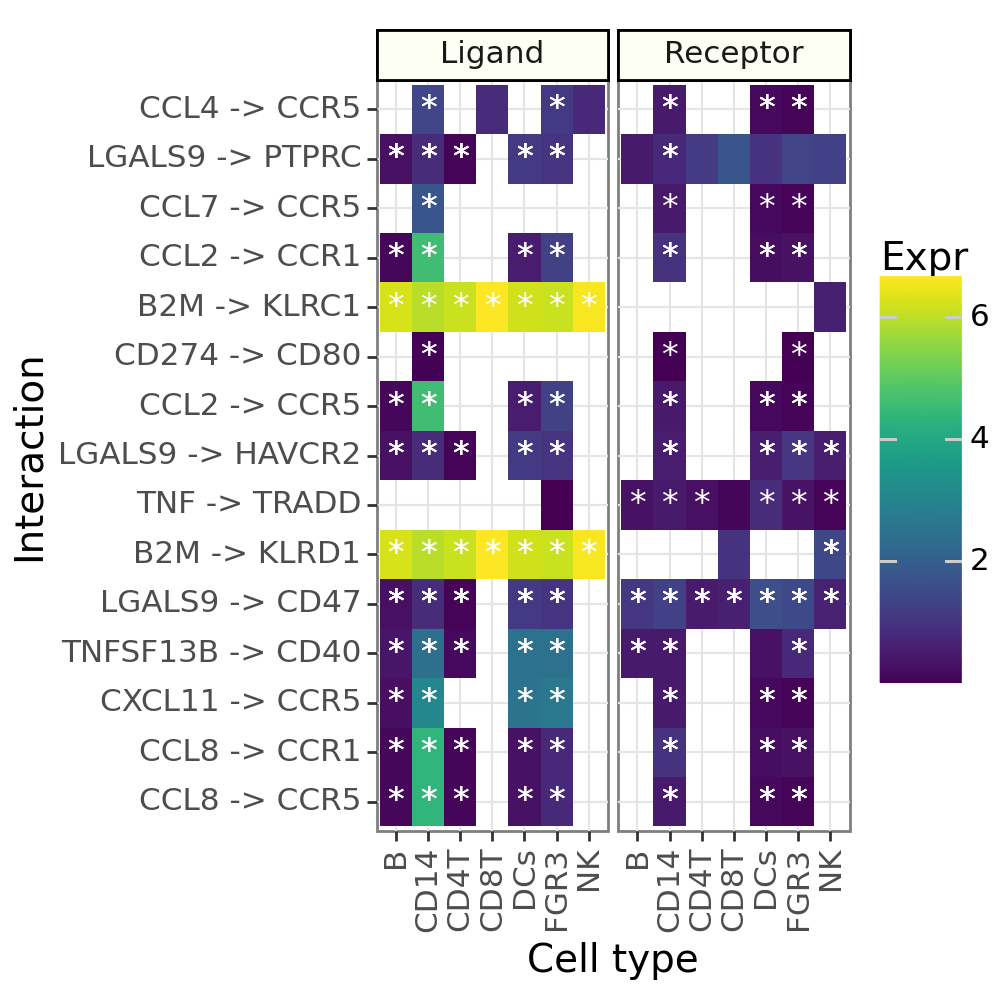

<Figure Size: (500 x 500)>

In [54]:
li.pl.tileplot(liana_res=lr_res,
               fill = 'expr',
               label='padj',
               label_fun = lambda x: '*' if x < 0.05 else np.nan,
               top_n=15,
               orderby = 'interaction_stat',
               orderby_ascending = False,
               orderby_absolute = False,
               source_title='Ligand',
               target_title='Receptor',
               )

sort by abs value of interaction stat

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_color_cmap could not recognise parameter `midpoint`
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


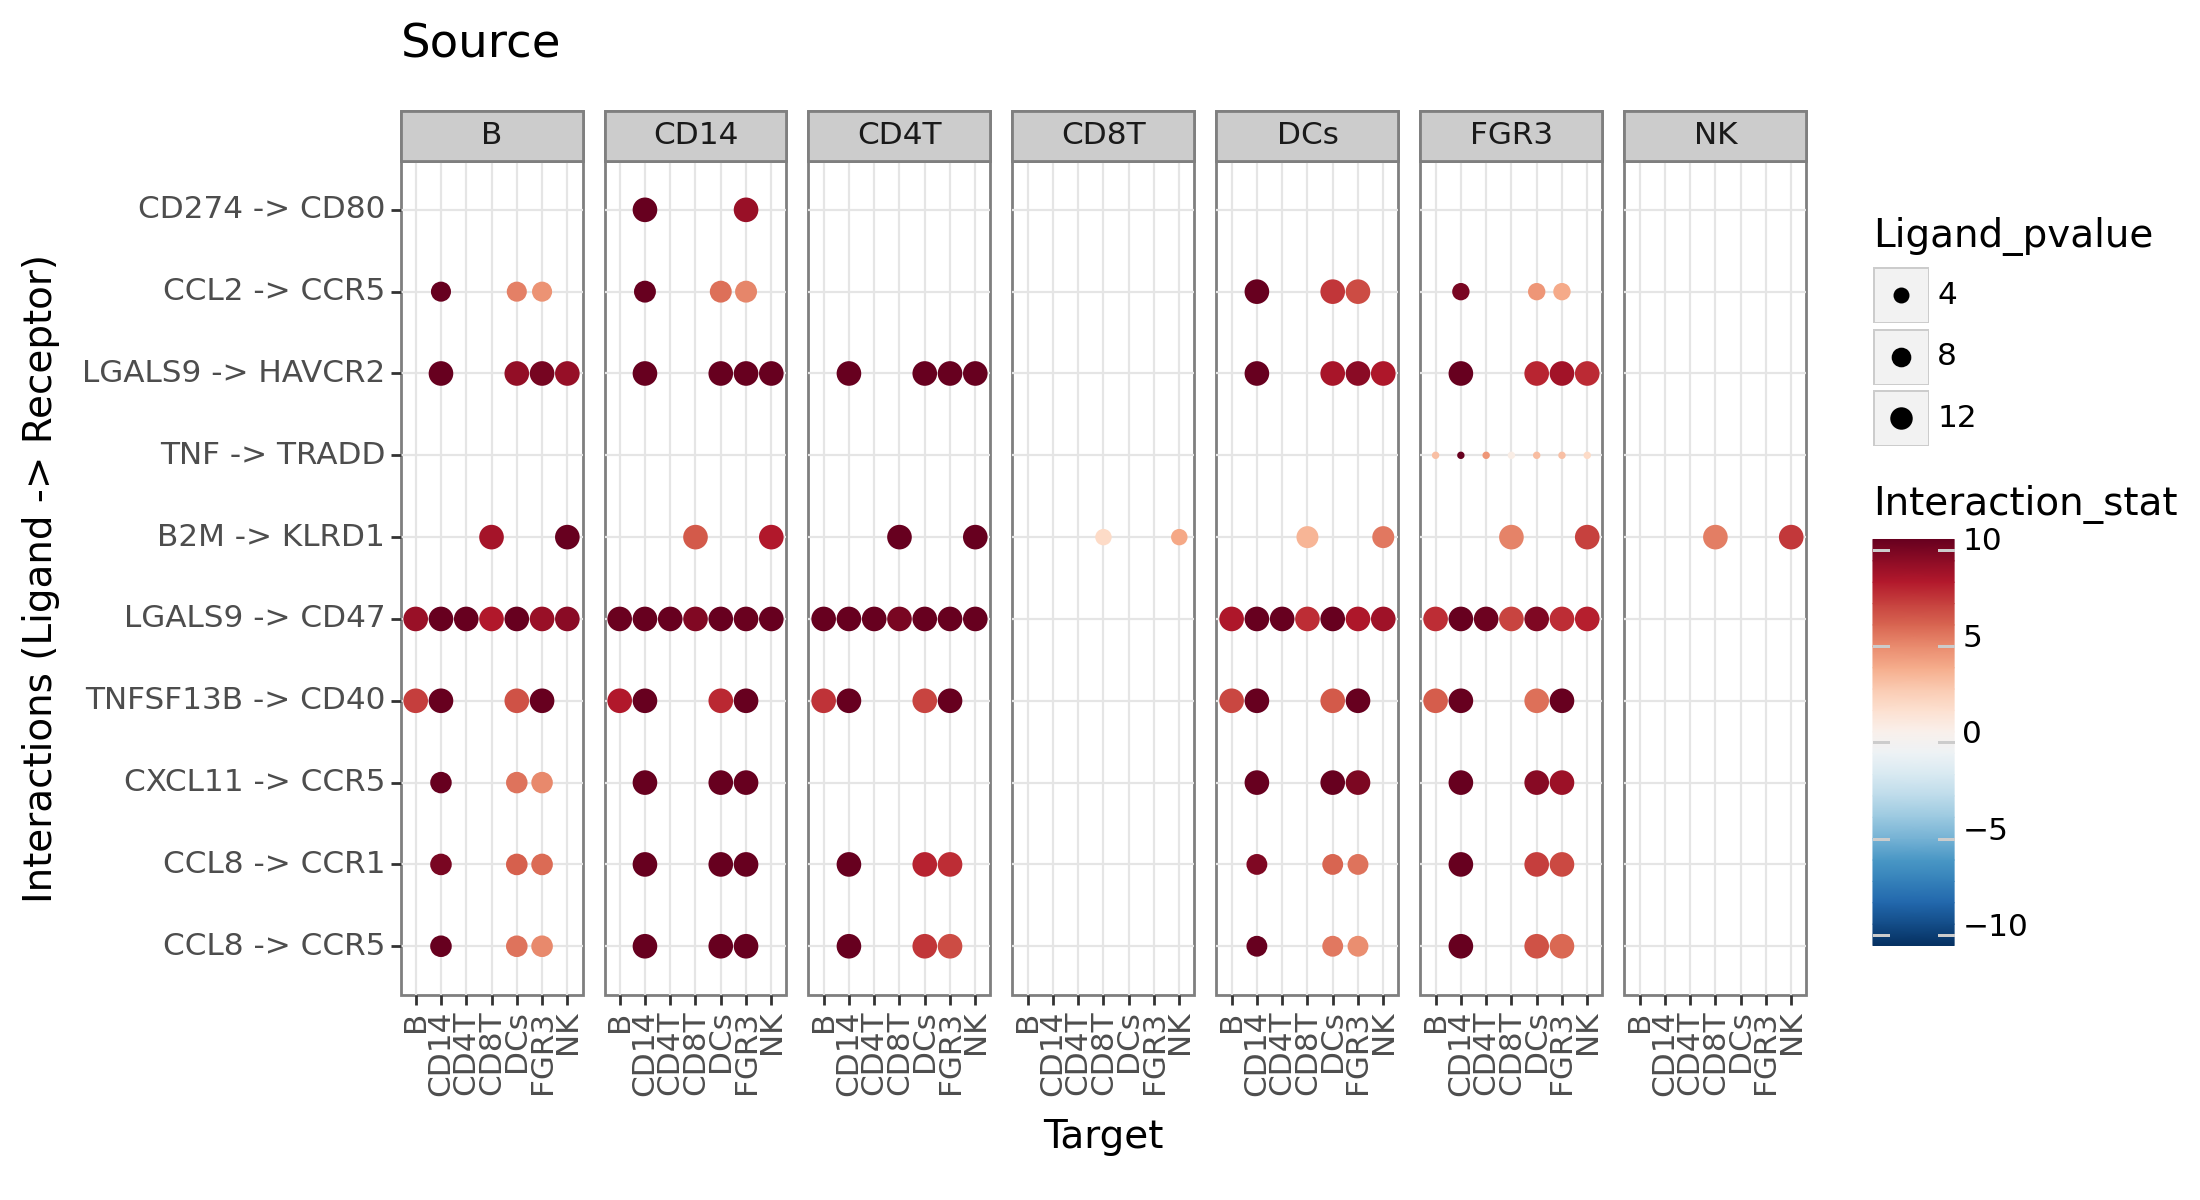

<Figure Size: (1100 x 600)>

In [55]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='ligand_pvalue',
                     inverse_size=True,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     orderby_absolute=True,
                     top_n=10,
                     size_range=(0.5, 4)
                     )

# customize plot
(
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, with 0 the middle
    + p9.scale_color_cmap('RdBu_r', midpoint=0, limits=(-10, 10))
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(11, 6))

)

In [69]:
dea_df.loc['LGALS9', :]

,cell_abbr,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
LGALS9,B,15.232777,3.321821,0.294110,11.325292,9.835066e-30,4.577776e-28
LGALS9,CD14,149.695953,3.307158,0.240189,13.838889,1.484842e-43,4.534413e-42
LGALS9,CD4T,33.641727,3.905060,0.272162,14.372896,7.656190e-47,6.701589e-45
LGALS9,CD8T,5.623934,5.309345,1.123949,5.092882,3.526616e-07,4.793319e-06
LGALS9,DCs,25.674332,2.556098,0.255970,10.178615,2.470523e-24,8.691748e-23
LGALS9,FGR3,31.684977,2.575230,0.293238,8.878222,6.793780e-19,1.588563e-17


In [67]:
dea_df.loc['CD47', :]

,cell_abbr,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CD47,B,69.179443,0.768349,0.133228,5.948991,2.698003e-09,3.801957e-08
CD47,CD14,314.707336,2.187565,0.147191,14.958709,1.366520e-50,5.708774e-49
CD47,CD4T,151.543335,0.945086,0.089328,10.753429,5.709875e-27,3.037214e-25
CD47,CD8T,14.935880,0.795398,0.178632,4.644296,3.412379e-06,4.169990e-05
CD47,DCs,49.149780,1.431329,0.148312,9.806129,1.059553e-22,3.280376e-21
CD47,FGR3,76.511475,0.708492,0.120873,5.951362,2.659209e-09,2.407614e-08
CD47,NK,22.999506,1.177279,0.181321,6.744055,1.540266e-11,3.367234e-10


sort by down-regulation

In [58]:
lr_res = lr_res.sort_values("interaction_stat", ascending=True)
lr_res.head()

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_stat,ligand_pvalue,ligand_padj,ligand_expr,ligand_props,...,receptor_pvalue,receptor_padj,receptor_expr,receptor_props,interaction_stat,interaction_pvalue,interaction_padj,interaction_expr,interaction_props,interaction
1374,HMGB1,CXCR4,HMGB1,CXCR4,DCs,-6.869054,6.462920e-12,8.932679e-11,0.686028,0.450185,...,1.588115e-21,1.969866e-20,0.309648,0.160217,-8.199025,3.231460e-12,4.466340e-11,0.497838,0.305201,HMGB1^CXCR4
369,PKM,CD44,PKM,CD44,CD14,-7.751215,9.101724e-15,7.604673e-14,1.435021,0.667993,...,3.442324e-17,6.756504e-16,0.661012,0.383128,-8.090851,4.568074e-15,3.836119e-14,1.048017,0.525561,PKM^CD44
540,HMGB1,CXCR4,HMGB1,CXCR4,B,-5.565130,2.619565e-08,3.193375e-07,1.433113,0.567041,...,1.588115e-21,1.969866e-20,0.309648,0.160217,-7.547063,1.309783e-08,1.596688e-07,0.871380,0.363629,HMGB1^CXCR4
36,HMGB1,CXCR4,HMGB1,CXCR4,CD4T,-5.421565,5.907950e-08,1.245533e-06,1.152901,0.467242,...,1.588115e-21,1.969866e-20,0.309648,0.160217,-7.475281,2.953975e-08,6.227663e-07,0.731275,0.313729,HMGB1^CXCR4
392,CD14,ITGB2,CD14,ITGB2,CD14,-12.763150,2.633321e-37,6.395908e-36,0.476936,0.224955,...,3.209494e-02,6.976823e-02,0.308052,0.198594,-7.453188,1.604747e-02,3.488412e-02,0.392494,0.211774,CD14^ITGB2


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_color_cmap could not recognise parameter `midpoint`
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


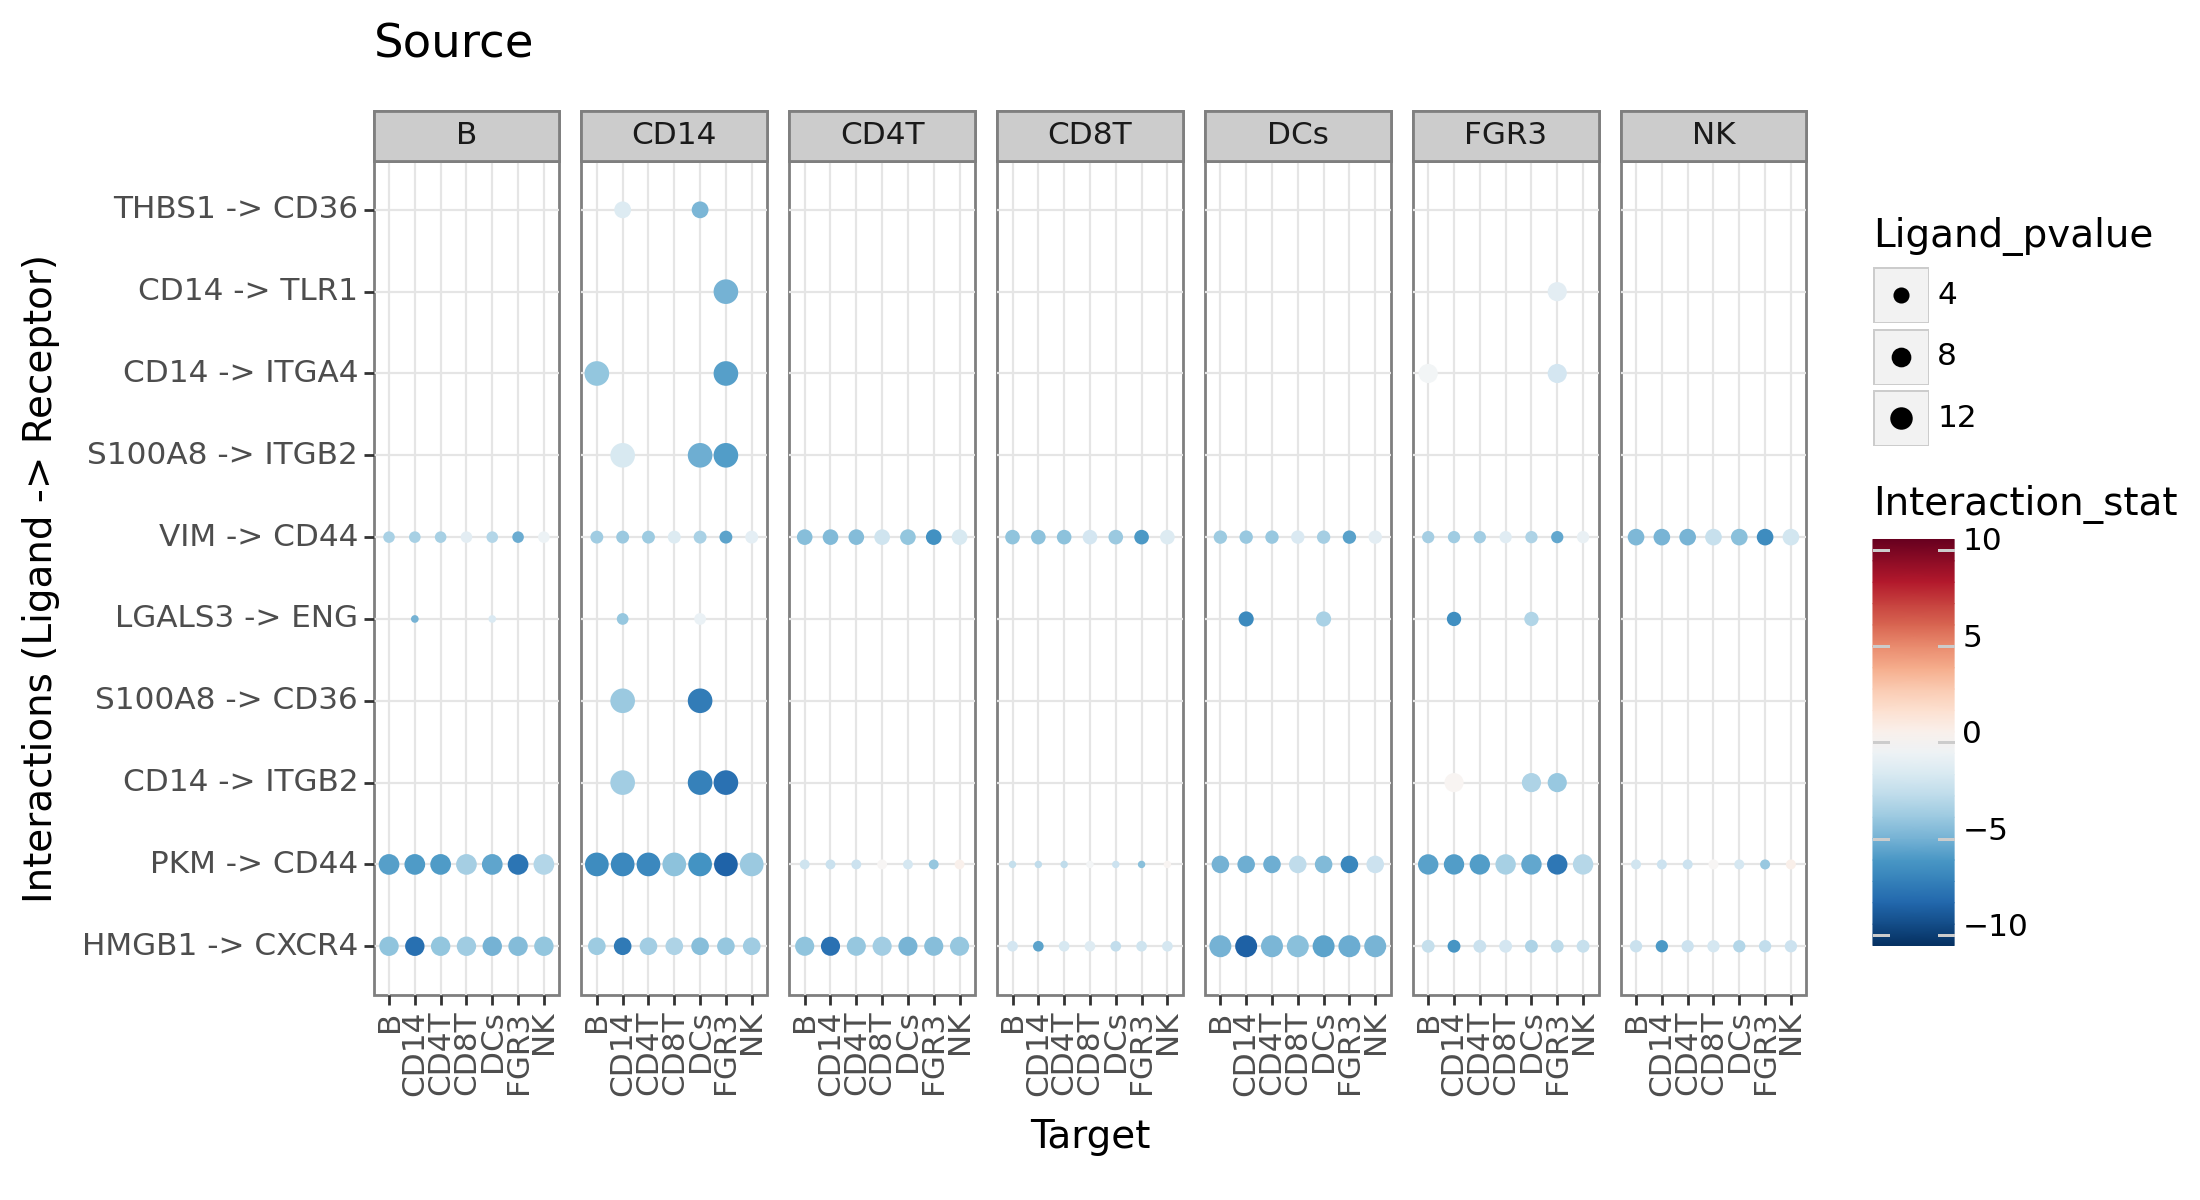

<Figure Size: (1100 x 600)>

In [61]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='ligand_pvalue',
                     inverse_size=True,
                     orderby='interaction_stat',
                     orderby_ascending=True,
                     orderby_absolute=False,
                     top_n=10,
                     size_range=(0.5, 4)
                     )

# customize plot
(
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, with 0 the middle
    + p9.scale_color_cmap('RdBu_r', midpoint=0, limits=(-10, 10))
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(11, 6))

)

In [63]:
dea_df.loc['PKM', :]

,cell_abbr,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
PKM,B,76.515327,-1.013391,0.169456,-6.228203,4.718150e-10,7.211024e-09
PKM,CD14,676.531494,-0.600753,0.078031,-7.751215,9.101724e-15,7.604673e-14
PKM,CD4T,221.431152,0.100979,0.154229,0.726290,4.676608e-01,7.126700e-01
PKM,CD8T,21.047033,0.009100,0.306685,0.036113,9.711923e-01,9.890123e-01
PKM,DCs,153.083420,-0.574953,0.125930,-4.622783,3.786255e-06,2.555722e-05
PKM,FGR3,65.770981,-1.096403,0.186689,-6.067968,1.295387e-09,1.222209e-08
PKM,NK,31.424314,0.139188,0.196589,0.793826,4.272968e-01,6.634820e-01


In [64]:
dea_df.loc['CD44', :]

,cell_abbr,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CD44,B,45.229549,-0.683838,0.147471,-4.846210,1.258422e-06,1.301641e-05
CD44,CD14,288.992554,-0.679866,0.134306,-5.143511,2.696515e-07,1.115785e-06
CD44,CD4T,356.727692,-0.528169,0.107967,-5.073470,3.906260e-07,7.524175e-06
CD44,CD8T,27.762922,-0.122625,0.311903,-0.499689,6.172943e-01,8.161289e-01
CD44,DCs,27.465307,-0.759851,0.184657,-4.255518,2.085655e-05,1.261169e-04
CD44,FGR3,57.574368,-1.362582,0.165380,-8.430486,3.442324e-17,6.756504e-16
CD44,NK,45.270859,0.078260,0.266045,0.361946,7.173927e-01,8.723355e-01
